<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [5]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

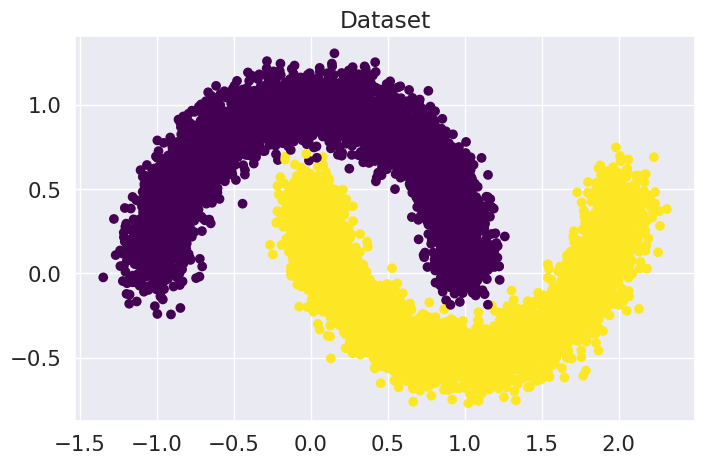

In [6]:
plt.figure(figsize=(8, 5))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [10]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [12]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [15]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [16]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [18]:
Train_Param_Amount = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)

print(f"Trained Parameters Amount is: {Train_Param_Amount}")

Trained Parameters Amount is: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [21]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # Using linear_regression to get outputs
        outp = outp.view(-1)
        loss = loss_function(outp, y_batch) # Computing loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)# Computing probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.234375
Iteration: 100
Batch accuracy: 0.46875
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.8359375

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 755

### Визуализируем результаты

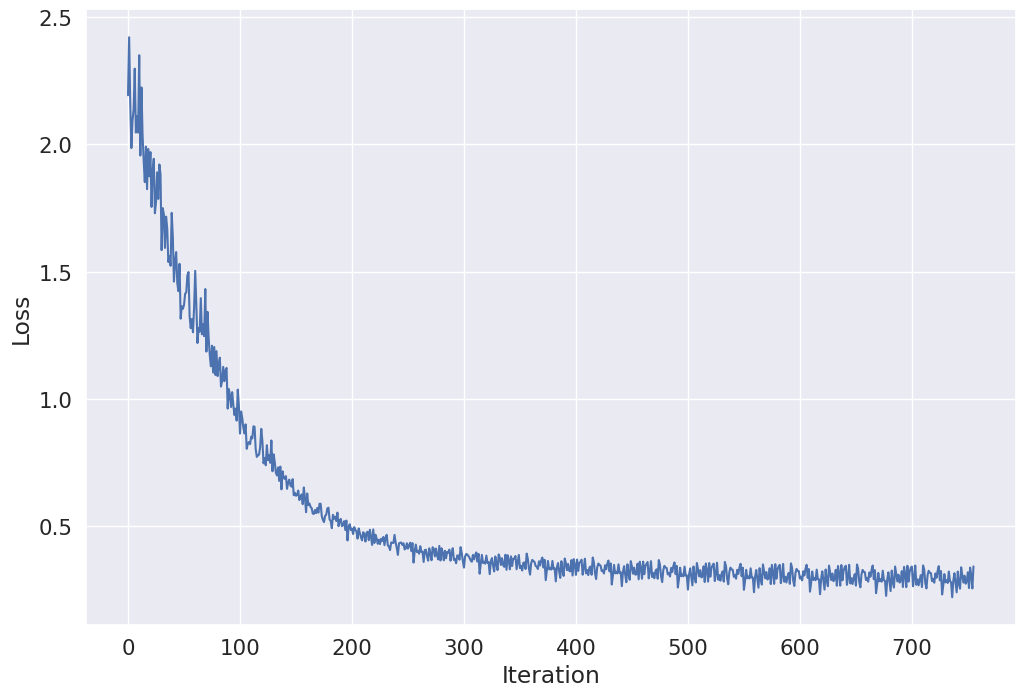

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

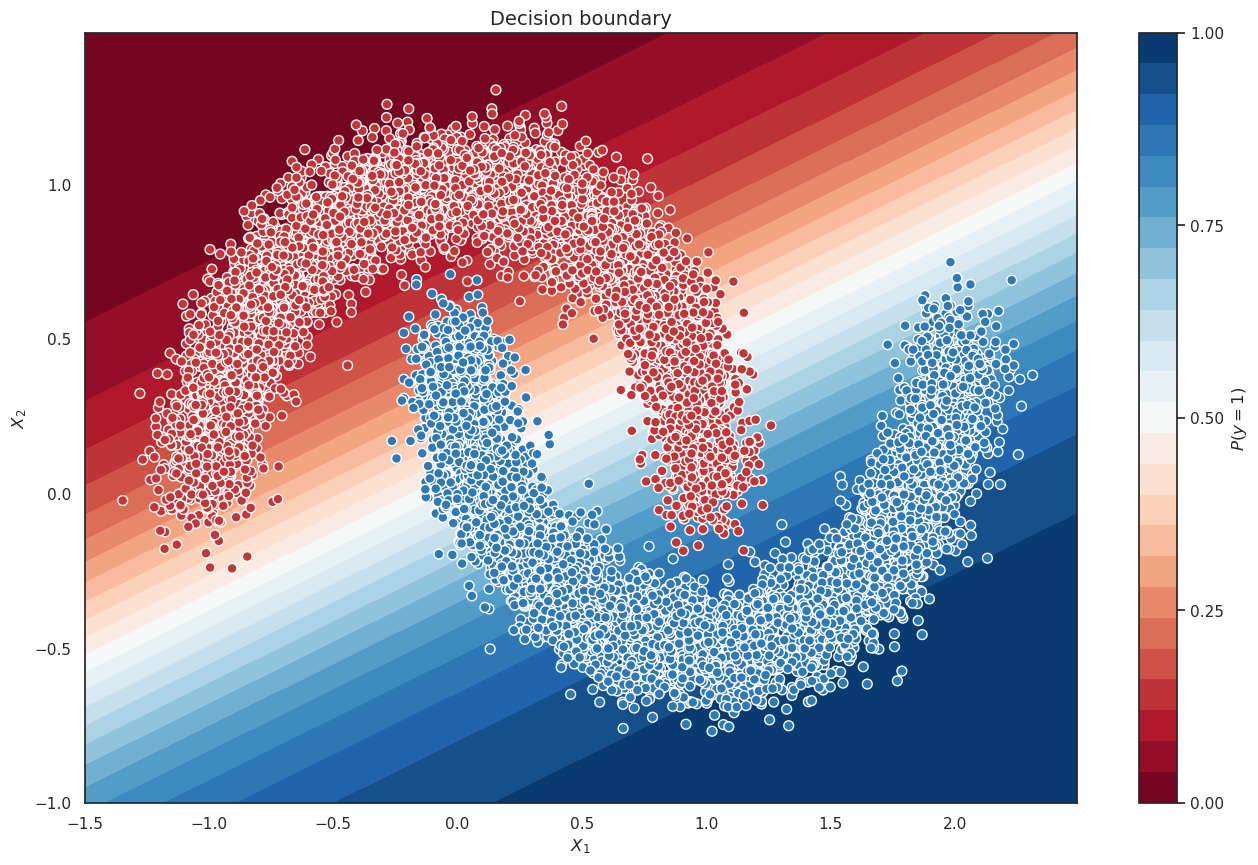

In [25]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [27]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = linear_regression(x_batch) # Using linear_regression to get outputs
        outp = outp.view(-1)
        probabilities = torch.sigmoid(outp)# Computing probabilities
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [28]:
from sklearn.metrics import accuracy_score

predictions = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(predictions, y_val_t)
print('total accuracy:', accuracy)

total accuracy: 0.8752


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0,875

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [31]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
#train_dataloader =  MNIST(root, train=True,  transform=data_tfs, download=True)
#valid_dataloader =  MNIST(root, train=False, transform=data_tfs, download=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [33]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [35]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    #Add layers to your sequential class
    nn.Linear(784,128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128,10)
)

In [36]:
criterion = nn.CrossEntropyLoss() #Selecting a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [40]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                #Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
            else:
                 #Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():  # Getting logits
                    output = model(x_batch)
                    
            preds = output.argmax(-1)
            correct = (preds==y_batch).float().sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.91185
Loader: valid. Accuracy: 0.9551
Epoch: 2
Loader: train. Accuracy: 0.9557
Loader: valid. Accuracy: 0.9621
Epoch: 3
Loader: train. Accuracy: 0.9661333333333333
Loader: valid. Accuracy: 0.9691
Epoch: 4
Loader: train. Accuracy: 0.96995
Loader: valid. Accuracy: 0.9675
Epoch: 5
Loader: train. Accuracy: 0.9741833333333333
Loader: valid. Accuracy: 0.9671
Epoch: 6
Loader: train. Accuracy: 0.9761833333333333
Loader: valid. Accuracy: 0.9732
Epoch: 7
Loader: train. Accuracy: 0.9783166666666666
Loader: valid. Accuracy: 0.9723
Epoch: 8
Loader: train. Accuracy: 0.9803
Loader: valid. Accuracy: 0.9704
Epoch: 9
Loader: train. Accuracy: 0.9812833333333333
Loader: valid. Accuracy: 0.9749
Epoch: 10
Loader: train. Accuracy: 0.9824333333333334
Loader: valid. Accuracy: 0.9687


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [42]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9551,
 0.9621,
 0.9691,
 0.9675,
 0.9671,
 0.9732,
 0.9723,
 0.9704,
 0.9749,
 0.9687]

In [43]:
#Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,128),
        activation(),
        nn.Linear(128,128),
        activation(),
        nn.Linear(128,10)
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    output = model(x_batch)
                    
                else:
                    model.eval()
                    with torch.no_grad():
                        output = model(x_batch)
                    
                preds = output.argmax(-1)
                correct = (preds==y_batch).float().sum()
                all =  len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(output, y_batch)
                    loss.backward()
                    optimizer.step()
                    
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    del model    
    return accuracy

In [44]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

plain_accuracy_val = plain_accuracy["valid"]
relu_accuracy_val = relu_accuracy["valid"]
leaky_relu_accuracy_val = leaky_relu_accuracy["valid"]

Epoch: 1
Loader: train. Accuracy: 0.8665333333333334
Loader: valid. Accuracy: 0.8851
Epoch: 2
Loader: train. Accuracy: 0.8901
Loader: valid. Accuracy: 0.9008
Epoch: 3
Loader: train. Accuracy: 0.8964166666666666
Loader: valid. Accuracy: 0.9025
Epoch: 4
Loader: train. Accuracy: 0.9015333333333333
Loader: valid. Accuracy: 0.9016
Epoch: 5
Loader: train. Accuracy: 0.9042166666666667
Loader: valid. Accuracy: 0.9019
Epoch: 6
Loader: train. Accuracy: 0.9073666666666667
Loader: valid. Accuracy: 0.9093
Epoch: 7
Loader: train. Accuracy: 0.9084
Loader: valid. Accuracy: 0.9167
Epoch: 8
Loader: train. Accuracy: 0.9104666666666666
Loader: valid. Accuracy: 0.9115
Epoch: 9
Loader: train. Accuracy: 0.9101333333333333
Loader: valid. Accuracy: 0.897
Epoch: 10
Loader: train. Accuracy: 0.91175
Loader: valid. Accuracy: 0.913
Epoch: 1
Loader: train. Accuracy: 0.9019166666666667
Loader: valid. Accuracy: 0.9449
Epoch: 2
Loader: train. Accuracy: 0.9510833333333333
Loader: valid. Accuracy: 0.9522
Epoch: 3
Loader:

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

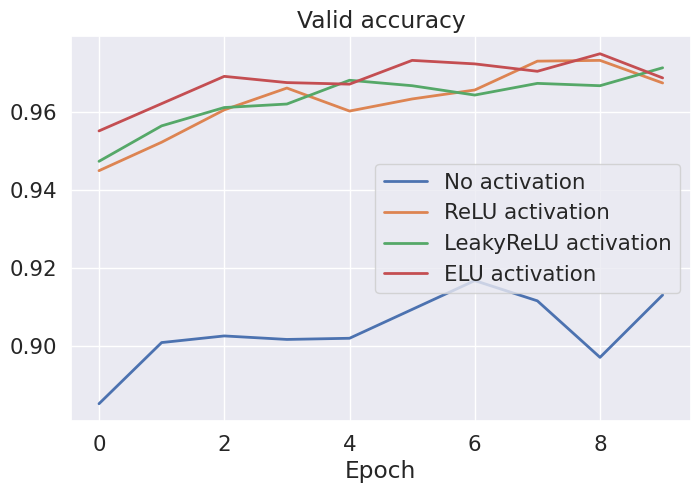

In [46]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy_val, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy_val, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy_val, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

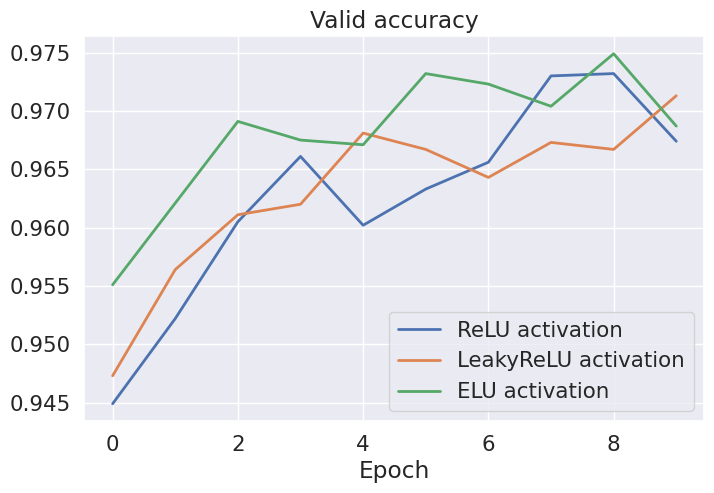

In [47]:
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy_val, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy_val, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [51]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-11-11 02:52:44--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K   211KB/s    in 0,2s    

2024-11-11 02:52:45 (211 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



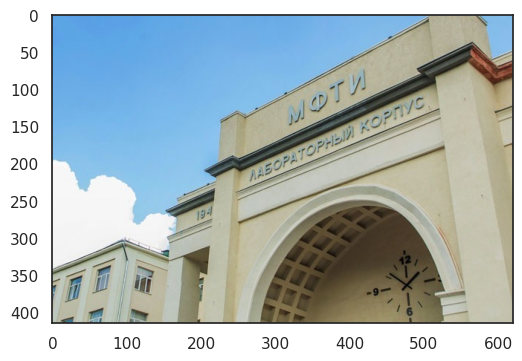

In [52]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 4))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])


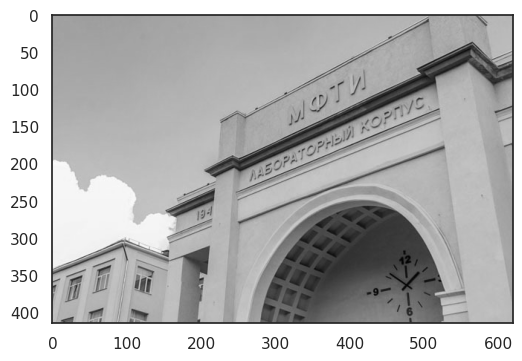

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79296875..1.0351562].


tensor([[[[ 0.,  1.,  0.],
          [ 0., -2.,  0.],
          [ 0.,  1.,  0.]]]])


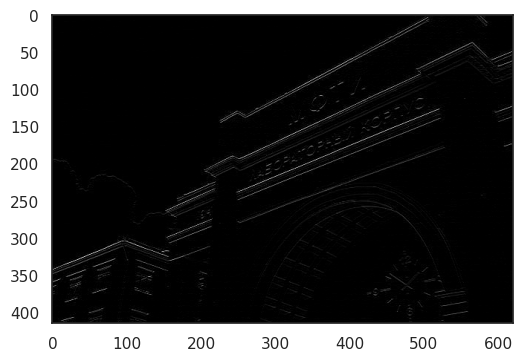

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76692706..0.81901044].


tensor([[[[ 0.,  0.,  0.],
          [ 1., -2.,  1.],
          [ 0.,  0.,  0.]]]])


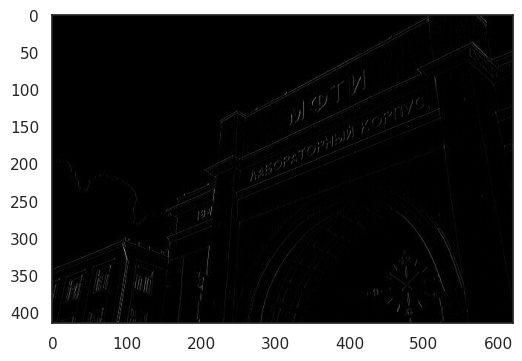

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1679688..1.4140625].


tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


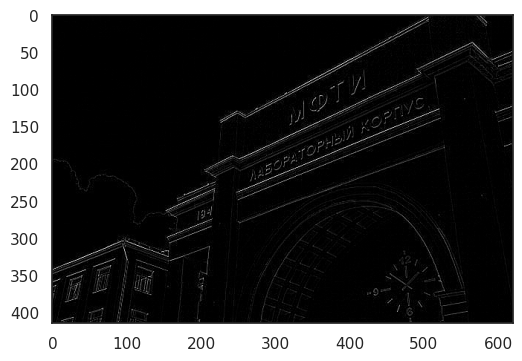

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2005209..2.0546875].


tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


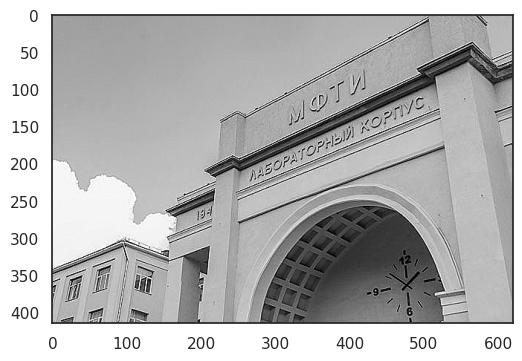

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


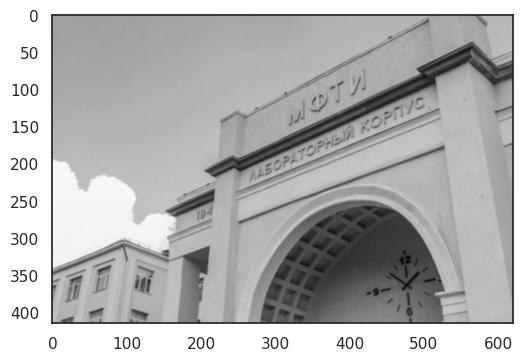

In [102]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)

kernel_a = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_b = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_v = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_g = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_d = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_e = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel_set = [kernel_a, kernel_b, kernel_v, kernel_g, kernel_d, kernel_e]
for kernel in kernel_set:
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    print(kernel)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]
    plt.figure(figsize=(6, 4))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    plt.imshow(result_np)
    plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

А) Тождественное преобразование

Б) Выделение горизонтальных границ

В) Выделение вертикальных границ

Г) Выделение границ

Д) Увеличение резкости

Е) Размытие


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [57]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3) #in_channels=1, out_channels=6, kernel_size=3
        self.pool1 = nn.MaxPool2d(2,2) #kernel_size=2, stride=2
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(400, 120) #in_features = 5*5*16, out_features = 120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        # Apply layers created in __init__.
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [60]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
                
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
                
            preds = output.argmax(-1)
            correct = (preds==y_batch).float().sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9460833333333334
Loader: valid. Accuracy: 0.9743
Epoch: 2
Loader: train. Accuracy: 0.98245
Loader: valid. Accuracy: 0.9854
Epoch: 3
Loader: train. Accuracy: 0.9864833333333334
Loader: valid. Accuracy: 0.988
Epoch: 4
Loader: train. Accuracy: 0.98975
Loader: valid. Accuracy: 0.9889
Epoch: 5
Loader: train. Accuracy: 0.9918666666666667
Loader: valid. Accuracy: 0.9839
Epoch: 6
Loader: train. Accuracy: 0.9934166666666666
Loader: valid. Accuracy: 0.9897
Epoch: 7
Loader: train. Accuracy: 0.9945666666666667
Loader: valid. Accuracy: 0.9888
Epoch: 8
Loader: train. Accuracy: 0.9951
Loader: valid. Accuracy: 0.9892
Epoch: 9
Loader: train. Accuracy: 0.9955833333333334
Loader: valid. Accuracy: 0.9891
Epoch: 10
Loader: train. Accuracy: 0.99595
Loader: valid. Accuracy: 0.9884


In [61]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

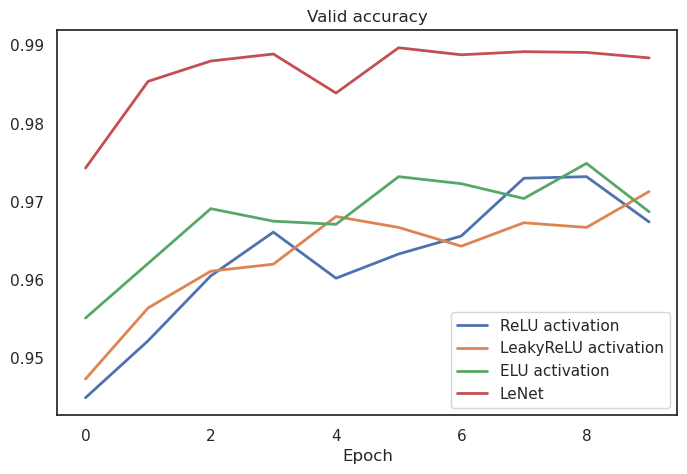

In [63]:
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy_val, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy_val, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,988